In [117]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Setup

In [54]:
M = np.array([0.576, 0.32 , 0.94 , 0.736, 0.996, 0.74 , 0.884, 0.836, 0.748,
       0.768, 0.804, 0.78 , 0.724, 0.68 , 0.656, 0.68 , 0.688, 0.72 ,
       0.768, 0.764, 0.816, 0.74 , 0.336, 0.628, 0.544, 0.664, 0.628,
       0.664, 0.604, 0.596, 1.236, 0.516, 0.608, 0.588, 0.616, 0.612,
       0.612, 0.608, 0.592, 0.584, 0.588, 0.592, 0.624, 0.668, 0.66 ,
       0.696, 0.708, 0.688, 0.744, 0.844, 0.932, 0.964, 1.012, 0.956,
       0.488, 0.424, 1.028, 0.824, 0.916, 0.9  , 0.904, 0.892, 0.876,
       0.784, 0.42 , 0.332, 0.768, 0.744, 0.78 , 0.832, 0.48 , 0.408,
       0.896, 0.896, 0.784, 0.744, 0.68 , 0.768, 0.596, 0.724, 0.676,
       0.644, 0.688, 0.728, 0.74 , 0.724, 0.74 , 0.772, 0.816, 0.832,
       0.828, 0.82 , 0.808, 0.8  , 0.76 , 0.732, 0.692, 0.712, 0.772,
       0.8  ])

N = np.size(M)

sigVScalar = 1e-3
sigXScalar = 1e-2

d = 1
mu0 = np.array([-0.91861314, 0.60239937])
sigv = np.identity(d+1)*sigVScalar
sig0 = np.identity(d+1)*sigXScalar

precisionv = np.linalg.inv(sigv)
precision0 = np.linalg.inv(sig0)

alphahat = 41.3

h = np.ones((d+1, N))
for k in range(N):
    h[1:min(d+1, k)+1, k] = M[max(k-d,0):k][::-1]

## 2) Langevin Monte Carlo

In [2]:
def lmcIteration(xk, eps, g):
    '''
    xk = current x vector
    eps = step size scalar
    g = gradient of f
    '''

    (n,) = xk.shape
    zk = np.random.multivariate_normal(np.zeros_like(xk), np.eye(n))
    x_plus = xk - eps**2/2 * g + eps*zk
    return x_plus

def logPx(x):
    (d1, N) = x.shape
    logp = np.log(stats.multivariate_normal.pdf(x[:,0], mu0, sig0))
    for j in range(1, N):
        logp += np.log(stats.multivariate_normal(x[:,j], x[:,j-1], sigv))
    
    for j in range(N):
        beta = -h[:,j].T @ x[:,j]
        logp += np.log(stats.gamma.pdf(M[j], a=alphahat, loc=0, scale=1/beta))
    return logp

def gradientX(x, prevX, postX, prePrec, postPrec, alphahat, y, h):
    g = prePrec @ (x - prevX) - postPrec @ (postX - x) \
        + alphahat * h - alphahat * y * np.exp(- h.T @ x) * h
    
    return g

def accept(x_plus, xk, eps, g):
    (_, N) = xk.shape
    qNewGivenOld = 0
    qOldGivenNew = 0
    for j in range(N):
        qNewGivenOld += np.log(stats.multivariate_normal.pdf(x_plus[:,j], xk[:,j] - eps**2/2 * g, eps**2*np.eye(N)))
        qOldGivenNew += np.log(stats.multivariate_normal.pdf(xk[:,j], x_plus[:,j] - eps**2/2 *g, eps**2*np.eye(N)))

    logPNew = logPx(x_plus)
    logPOld = logPx(xk)

    acceptProb = min(1, np.exp(logPNew + qOldGivenNew - logPOld - qNewGivenOld))
    acceptRes = stats.bernoulli.rvs(acceptProb)
    
    return acceptRes

In [105]:
S = 1000

def runLMC():
    # initialize
    xSamps = np.zeros((d+1, N, S))
    xSamps[:,0,0] = np.random.multivariate_normal(mu0, sig0)

    eps = 0.01

    burnIn = 50

    for i in range(1,N):
        xSamps[:,i,0] = np.random.multivariate_normal(xSamps[:,i-1,0], sigv)

    k = 1
    kBurn = 0
    while k < S:
        newSamp = np.empty((d+1, N))
        gs = np.empty((d+1,N))

        for j in range(N):
            if j == 0:
                prevX = mu0; postX = xSamps[:,j+1,k-1]
                prePrec = precision0; postPrec = precisionv
            elif j == N-1:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j,k-1]
                prePrec = precisionv; postPrec = precisionv
            else:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j+1,k-1]
                prePrec = precisionv; postPrec = precisionv
            currX = xSamps[:,j,k-1]

            gs[:,j] = gradientX(currX, prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])
            newSamp[:,j] = lmcIteration(currX, eps, gs[:,j])

        if accept(newSamp, xSamps[:,:,k-1], eps, gs):
            xSamps[:,:,k] = newSamp
        else:
            xSamps[:,:,k] = xSamps[:,:,k-1].copy()
        
        if kBurn < burnIn:
            kBurn += 1
        elif kBurn == burnIn:
            xSamps[:,:,0] = xSamps[:,:,1]
        else:
            k += 1

    return xSamps


In [159]:
xSamps = runLMC()

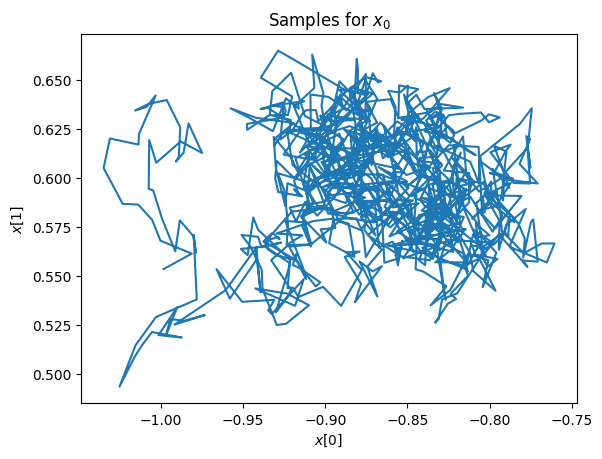

In [174]:

plotN = 0
vecs = np.diff(xSamps)

plt.plot(xSamps[0,plotN,:], xSamps[1,plotN,:])
plt.xlabel(r"$x$[0]")
plt.ylabel(r"$x$[1]")
plt.title(rf"Samples for $x_{{{plotN}}}$")
# plt.quiver((xSamps[0,plotN,:-1], xSamps[1,plotN,:-1]), vecs[0, plotN,:], vecs[1,plotN,:])
plt.show()

## 3) Estimate expectation with LMC

In [150]:
def evalExpectationApprox(xSamps):
    (_, N, S) = xSamps.shape
    expectation = 0
    for k in range(S):
        betas = alphahat * np.exp(-np.sum(np.multiply(h, xSamps[:,:,k]), axis=0))
        for j in range(N):
            expectation += 1/S * np.log(stats.gamma.pdf(M[j], a=alphahat, loc=0, scale=1/betas[j]))
    return expectation

In [132]:
currXSamps = runLMC()


In [149]:
expec = evalExpectationApprox(currXSamps)
print(expec)

6.199893333282091


In [151]:
numTrials = 100
expResults = np.zeros((numTrials,))

startTime = time.time()
for i in range(numTrials):
    if i % 10 == 0:
        currTime = time.time()
        print("Trial ", i, " Time (s): ", currTime - startTime)
        startTime = currTime
        
    currXSamps = runLMC()
    expResults[i] = evalExpectationApprox(currXSamps)

Trial  0  Time (s):  0.00036978721618652344
Trial  10  Time (s):  219.0518651008606
Trial  20  Time (s):  219.5293049812317
Trial  30  Time (s):  213.07683300971985
Trial  40  Time (s):  215.88222002983093
Trial  50  Time (s):  221.36953592300415
Trial  60  Time (s):  216.09003710746765
Trial  70  Time (s):  214.65997695922852
Trial  80  Time (s):  214.27222204208374
Trial  90  Time (s):  214.61978888511658


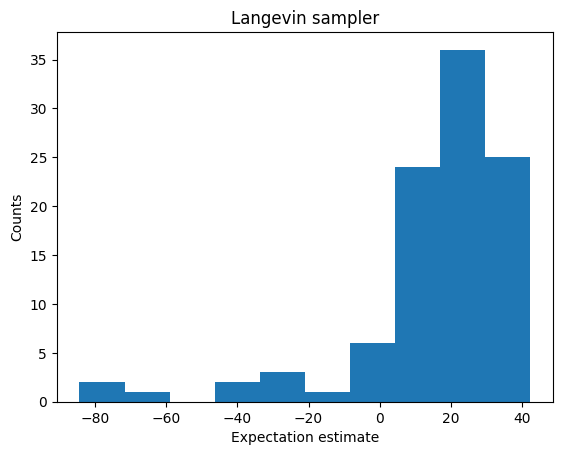

In [153]:
plt.hist(expResults)
plt.xlabel("Expectation estimate")
plt.ylabel("Counts")
plt.title("Langevin sampler")
plt.show()